In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import os

from src.util import generate_node_cargo_size_change, calculate_single_truck_deviation, ConsoleLogger
from src.pdpt_ini_sol import solve_pdotw_mip
import pickle

dir_ = '/home/tan/Documents'

In [2]:
def toy_example():
    ins = {}
    num_node = 16
    constant = {'truck_fixed_cost': 30000.0, 
                'truck_running_cost': 50.0, 
                'cargo_reloading_cost': 0.5, 
                'node_fixed_time': 11.0, 
                'loading_variation_coefficient': 0.0094598
               }
    loc = [[0.00,  0.00], #node 1
        [1.50, -0.50], #node 2
        [2.00, -0.75], #node 3
        [2.50, -0.75], #node 4
        [3.50, -0.75], #node 5
        [4.00, -0.50], #node 6
        [5.00, -0.75], #node 7
        [5.20, -1.75], #node 8
        [3.00, -0.50], #node 9
        [4.50,  0.00], #node 10
        [1.00, -1.25], #node 11
        [0.75, -1.75], #node 12
        [0.25, -2.00], #node 13
        [2.50, -1.75], #node 14
        [3.00, -2.50], #node 15
        [3.75, -2.00], #node 16
        ]

    node_list = [f'N{i+1}' for i in range(num_node)]

    # cargo['nb_cargo'] = ['size', 'lb_time', 'ub_time', 'departure_node', 'arrival_node']
    cargo = {'C1': [10, 0, 100, 0,  1], #cargo 1
            'C2': [10, 0, 100, 10, 11], #cargo 2
            'C3': [10, 0, 100,  9, 12], #cargo 3
            'C4': [10, 0, 100,  2,  6], #cargo 4
            'C5': [10, 0, 100,  8,  3], #cargo 5
            'C6': [10, 0, 100,  4,  6], #cargo 6
            'C7': [10, 0, 100, 13, 15], #cargo 7
            'C8': [10, 0, 100,  2, 14], #cargo 8
            }

    # truck['nb_truck'] = ['departure_node', 'arrival_node', 'max_worktime', 'max_capacity']

    truck = {'T1':[ 0,  7, 100, 100],
             'T2':[ 9, 12, 100, 100],
             'T3':[ 3, 15, 100, 100],
            }

    edge_shortest = {(i,j): round(sqrt((loc[i][0]-loc[j][0])**2 +(loc[i][1]-loc[j][1])**2),2)for i in range(num_node) for j in range(num_node)}
    node_cargo_size_change = generate_node_cargo_size_change(node_list, cargo)
    single_truck_deviation = calculate_single_truck_deviation(truck, cargo, edge_shortest)

    dict_ = {'constant': constant,
             'cargo': cargo,
             'truck': truck,
             'nodes': node_list,
             'node_cargo_size_change': node_cargo_size_change,
             'edge_shortest': edge_shortest,
             'single_truck_deviation': single_truck_deviation,
             'loc': loc
            }
    path_ = dir_+'/toy.pkl'
    with open(path_, 'wb') as pickle_file:
        pickle.dump(dict_, pickle_file)

    return dict_

In [3]:
ins_ = toy_example()

{(0, 0): 0.0, (0, 1): 1.58, (0, 2): 2.14, (0, 3): 2.61, (0, 4): 3.58, (0, 5): 4.03, (0, 6): 5.06, (0, 7): 5.49, (0, 8): 3.04, (0, 9): 4.5, (0, 10): 1.6, (0, 11): 1.9, (0, 12): 2.02, (0, 13): 3.05, (0, 14): 3.91, (0, 15): 4.25, (1, 0): 1.58, (1, 1): 0.0, (1, 2): 0.56, (1, 3): 1.03, (1, 4): 2.02, (1, 5): 2.5, (1, 6): 3.51, (1, 7): 3.91, (1, 8): 1.5, (1, 9): 3.04, (1, 10): 0.9, (1, 11): 1.46, (1, 12): 1.95, (1, 13): 1.6, (1, 14): 2.5, (1, 15): 2.7, (2, 0): 2.14, (2, 1): 0.56, (2, 2): 0.0, (2, 3): 0.5, (2, 4): 1.5, (2, 5): 2.02, (2, 6): 3.0, (2, 7): 3.35, (2, 8): 1.03, (2, 9): 2.61, (2, 10): 1.12, (2, 11): 1.6, (2, 12): 2.15, (2, 13): 1.12, (2, 14): 2.02, (2, 15): 2.15, (3, 0): 2.61, (3, 1): 1.03, (3, 2): 0.5, (3, 3): 0.0, (3, 4): 1.0, (3, 5): 1.52, (3, 6): 2.5, (3, 7): 2.88, (3, 8): 0.56, (3, 9): 2.14, (3, 10): 1.58, (3, 11): 2.02, (3, 12): 2.57, (3, 13): 1.0, (3, 14): 1.82, (3, 15): 1.77, (4, 0): 3.58, (4, 1): 2.02, (4, 2): 1.5, (4, 3): 1.0, (4, 4): 0.0, (4, 5): 0.56, (4, 6): 1.5, (4, 7)

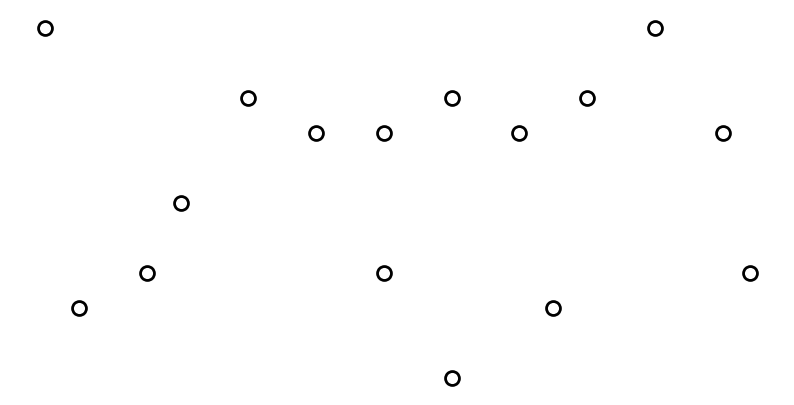

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(*np.array(ins_['loc']).T, 'o',ms =10, mfc='None', mec='k', mew=2)
ax.axis('off')
fig.savefig(dir_+'/toy.png', dpi=150, transparent=True)

In [5]:
def pdpt_ini_sol(dir_, greedy_initialization, verbose = 0):


    # for case_num in range(1, 6, 1):
    if verbose > 0:
        print('=========== START READ RAW DATA FROM CSV TO PICKLE FILES ===========')

    with open(dir_+'/toy.pkl', 'rb') as pkl_file:
            pdpt_ins = pickle.load(pkl_file)

    if verbose >0: 
        print('=========== END  =========== \n')


    if verbose > 0:
        print('=========== START CONSTRUCT INITIAL SOLUTION BY SOLVING MULTIPLE PDOTW PROBLEMS ===========')
    path_ = dir_+'/toy'
    res = solve_pdotw_mip(pdpt_ins, path_, greedy_initialization, verbose)
    if verbose >0: 
        print('=========== END INITIAL SOLUTION  =========== \n')

    filename = dir_+'toy_initSol_all.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(res, f)


In [6]:
# logfile = os.path.join(dir_+'/toy.log')
# ConsoleLogger.start(logfile, mode='w', time_format='[%m-%d %H:%M:%S]')

pdpt_ini_sol(dir_, greedy_initialization=False, verbose = 0)

# ConsoleLogger.stop()


Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-24
Set parameter TimeLimit to value 100
Set parameter LogFile to value "/home/tan/Documents/toy_gurobi/truckT1.log"
Set parameter Heuristics to value 0.5
+++ MP [Feasible] 
   [Gurobi obj value] is 202000
   [The ]Gurobi runtime] is 100.001579
    The cargo C1 has been carried by truck T1
    The cargo C4 has been carried by truck T1
    The cargo C5 has been carried by truck T1
    The cargo C6 has been carried by truck T1
+++ Truck T1 has arrived at its real destination!
+++ The truck_route:
        ('T1', [0, 8, 3, 1, 2, 4, 6, 7])
        ('T2', [9])
        ('T3', [3])
+++ Summary of postprocessing
   [The truck_used] size: 1
       ['T1']
   [The truck_route] size: 3
       ('T1', [0, 8, 3, 1, 2, 4, 6, 7])
       ('T2', [9])
       ('T3', [3])
   [The cargo_delivered] size: 4
       ('C1', ('T1', [0, 8, 3, 1]))
       ('C4', ('T1', [2, 4, 6]))
       ('C5', ('T1', [8, 3]))
       ('C6', ('T1', 